In [3]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
import gradient_analyze as ga
import hp_file

In [4]:
g = np.array([-0.3376,  0.1305,  0.2561, -0.3416,  0.    ])
f = -g

sigma0 = 0.37001625825528

def lam(N):
    return 1 / (1 + (len(g) * sigma0 ** 2 / (2 * N * np.sum(g ** 2))))

In [3]:
filename = './results.pickle'

with open(filename, "rb") as file:
    results = pickle.load(file)

In [6]:
f = lambda x, y: np.sum((np.array(x, dtype="float64") - np.array(y, dtype="float64")) ** 2)

ga.calculate_new_quantity(['g_fd', 'g_ex'], 'g_fd_err', f, results, hp_file)
ga.calculate_new_quantity(['g_ps', 'g_ex'], 'g_ps_err', f, results, hp_file)

In [8]:
results_processed = ga.avg_quantities(['g_fd_err', 'g_ps_err'], results, hp_file)

In [9]:
results_processed_accessed = ga.access_quantities(['g_fd_err', 'g_ps_err'], results, hp_file)

In [11]:
with open('results_processed.pickle', "wb") as file:
    pickle.dump(results_processed, file)

In [12]:
with open('results_processed_accessed.pickle', "wb") as file:
    pickle.dump(results_processed_accessed, file)

In [13]:
with open('results_processed_accessed_ang.pickle', "wb") as file:
    pickle.dump(results_processed_accessed_ang, file)

In [5]:
with open('results_processed.pickle', "rb") as file:
    results_processed = pickle.load(file)

In [6]:
with open('results_processed_accessed.pickle', "rb") as file:
    results_processed_accessed = pickle.load(file)

In [8]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
coeffs = np.load("../grad-sim-fitting/coeffs.npy")

In [10]:
hlist = [0.05, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24,
       0.26, 0.28, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.44, 0.45,
       0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67,
       0.69, 0.71, 0.73, 0.75, 0.77, 0.8 , 0.82, 0.83, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 ,
       1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.22, 1.24, 1.27, 1.29, 1.31,
       1.33, 1.35, 1.37, 1.39, 1.41, 1.43, 1.45, 1.47, 1.49, 1.51, 1.53,
       1.55, 1.57, 1.59, 1.61, 1.63, 1.65, 1.67, 1.69, 1.71, 1.73,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ]

In [12]:
coeffs = {hlist[i]: c for i, c in enumerate(coeffs)}

In [13]:
def delta_fd_h(h, N):
    t1 = coeffs[h] / (4 * N * h ** 2 * len(f))
    t2 = f ** 2 * h ** 4 / 36
    return t1 + t2

def delta_fd(h, N):
    return np.array([delta_fd_h(h_, N) for h_ in h])

def h_fd_opt(N):
    
    numerator = 9 * len(f) * sigma0
    denominator = N * np.sum(f ** 2)
    
    return np.power(numerator / denominator, 1 / 6)

def delta_ps(h, N):
    return [coeffs[h_] / (4 * N * np.sin(h_) ** 2 ) for h_ in h]

def delta_ps_opt(N):
    return delta_ps([1.57], N)[0]

def delta(h, N):
    f_big = np.expand_dims(f, axis=0)
    h_big = np.expand_dims(h, axis=1)
    t1 = sigma0 / (2 * N * h_big ** 2)
    t2 = f_big ** 2 * h_big ** 4 / 36
    return t1 + t2

In [14]:
sigma0

0.37001625825528

1000


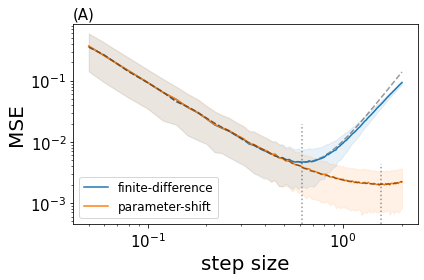

In [16]:
n_shots = [10, 14, 20, 29, 41, 59, 84, 100, 119, 170, 242, 346, 492, 702, 1000, 1425, 2031, 2894,
           4125, 5878, 8192, 8377, 11938, 17013, 24245, 34551, 49239, 70170, 100000][14]
print(n_shots)

results_slice = ga.calculate_slice({"n_shots": n_shots}, results_processed)
results_slice_acc = ga.calculate_slice({"n_shots": n_shots}, results_processed_accessed)
x, y_fd = ga.make_numpy(results_slice, "h", "g_fd_err")
x, y_ps = ga.make_numpy(results_slice, "h", "g_ps_err")

stds_fd = []
stds_ps = []

for h in x:
    errors = list(ga.calculate_slice({"h": h}, results_slice_acc).values())[0]
    errors_fd = errors["g_fd_err"]
    errors_ps = errors["g_ps_err"]
    
    stds_fd.append(np.std(errors_fd))
    stds_ps.append(np.std(errors_ps))

stds_fd = np.array(stds_fd)
stds_ps = np.array(stds_ps)

fd_pred = np.sum(delta_fd(x, n_shots), axis=1)
ps_pred = delta_ps(x, n_shots)

hopt = h_fd_opt(n_shots)

plt.fill_between(x, y_fd - stds_fd, y_fd + stds_fd, color=cols[0], alpha=0.1)
plt.fill_between(x, y_ps - stds_ps, y_ps + stds_ps, color=cols[1], alpha=0.1)
plt.plot(x, fd_pred, "--", c="black", alpha=0.4)
plt.plot(x, y_fd, label="finite-difference", c=cols[0])
plt.plot(x, y_ps, label="parameter-shift", c=cols[1])
plt.plot(x, ps_pred, "--", c="black", alpha=0.4)
plt.axvline(hopt, c="black", alpha=0.4, linestyle=":", ymax=0.5)
plt.axvline(np.pi / 2, c="black", alpha=0.4, linestyle=":", ymax=0.3)
plt.xlabel('step size', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)

plt.yscale("log")

plt.title("(A)", loc="left", fontsize=15)
plt.tight_layout()
plt.savefig("fd-vs-ps-simulator.pdf")
# plt.ylim(10**-5.25, 10**(-0.95))

In [17]:
hopt

0.6131730103358078

In [18]:
max_point = 8
y_fit_low = np.log(y_fd[:max_point])
x_fit_low = np.log(x[:max_point])

p = np.polyfit(x_fit_low, y_fit_low, 1)
print(p[0])

y_fit_low = p[0] * np.log(x) + p[1]
y_fit_low = np.exp(y_fit_low)

-1.9640487008096974


In [20]:
min_point = 80
max_point = 99
y_fit_high = np.log(y_fd[min_point:max_point])
x_fit_high = np.log(x[min_point:max_point])

pp = np.polyfit(x_fit_high, y_fit_high, 1)
print(pp[0])

y_fit_high = pp[0] * np.log(x) + pp[1]
y_fit_high = np.exp(y_fit_high)

3.282018644171291


In [22]:
min_point = 40
max_point = 50
y_fit_high_ = np.log(y_fd[min_point:max_point])
x_fit_high_ = np.log(x[min_point:max_point])

ppp = np.polyfit(x_fit_high_, y_fit_high_, 1)
print(ppp[0])

y_fit_high_ = ppp[0] * np.log(x) + ppp[1]
y_fit_high_ = np.exp(y_fit_high_)

2.3735501846406324


In [24]:
h_opt_fd_list = []
h_opt_ps_list = []

n_shots_list = [10, 14, 20, 29, 41, 59, 84, 100, 119, 170, 242, 346, 492, 702, 1000, 1425, 2031, 2894,
           4125, 5878, 8192, 8377, 11938, 17013, 24245, 34551, 49239, 70170, 100000]

mins_fd = []
mins_ps = []

for n_shots in n_shots_list:

    results_slice = ga.calculate_slice({"n_shots": n_shots}, results_processed)
    results_slice_acc = ga.calculate_slice({"n_shots": n_shots}, results_processed_accessed)
    x, y_fd = ga.make_numpy(results_slice, "h", "g_fd_err")
    x, y_ps = ga.make_numpy(results_slice, "h", "g_ps_err")
    
    y_fd_min = np.min(y_fd)
    y_ps_min = np.min(y_ps)
    
    xs_fd = x[np.argwhere(np.abs(y_fd - y_fd_min) < y_fd_min * 0.2).flatten()]
    xs_ps = x[np.argwhere(np.abs(y_ps - y_ps_min) < y_ps_min * 0.2).flatten()]

    mins_fd.append(y_fd_min)
    mins_ps.append(y_ps_min)
    
    h_opt_fd_list.append(xs_fd)
    h_opt_ps_list.append(xs_ps)

In [25]:
fd_mins = [np.min(x) for x in h_opt_fd_list]
fd_maxs = [np.max(x) for x in h_opt_fd_list]
fd_means = [np.mean(x) for x in h_opt_fd_list]

ps_mins = [np.min(x) for x in h_opt_ps_list]
ps_maxs = [np.max(x) for x in h_opt_ps_list]
ps_means = [np.mean(x) for x in h_opt_ps_list]

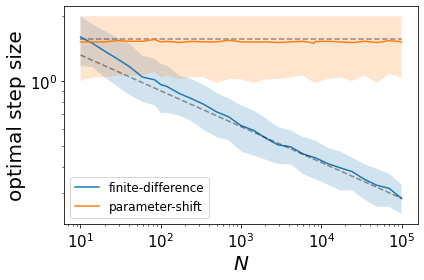

In [26]:
plt.fill_between(n_shots_list, fd_mins, fd_maxs, alpha=0.2)
plt.fill_between(n_shots_list, ps_mins, ps_maxs, alpha=0.2)
plt.plot(n_shots_list, fd_means, label="finite-difference")
plt.plot(n_shots_list, ps_means, label="parameter-shift")
plt.plot(n_shots_list, [h_fd_opt(n) for n in n_shots_list], "--", c="black", alpha=0.4)
plt.hlines(np.pi / 2, 10, 10**5, color="black", alpha=0.4, linestyles="dashed")
plt.yscale("log")
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.xlabel('$N$', fontsize=20)
plt.ylabel('optimal step size', fontsize=20)

plt.tight_layout()
plt.savefig("fd-vs-ps-simulator-opt-h.pdf")

In [27]:
opt_hs = [h_fd_opt(N) for N in n_shots_list]
err_expected = [np.sum(delta([opt_hs[i]], N)) for i, N in enumerate(n_shots_list)]

err_ps_expected = [delta_ps_opt(N) for N in n_shots_list]

In [28]:
crossover = np.argwhere(np.array(mins_fd) < np.array(mins_ps))[-1][0]

cross = (n_shots_list[crossover] + n_shots_list[crossover + 1]) / 2
cross

50.0

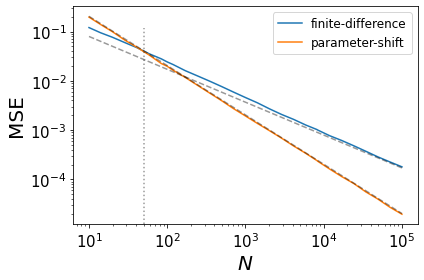

In [29]:
plt.plot(n_shots_list, mins_fd, label="finite-difference")
plt.plot(n_shots_list, mins_ps, label="parameter-shift")
plt.plot(n_shots_list, err_expected, "--", c="black", alpha=0.4)
plt.plot(n_shots_list, err_ps_expected, "--", c="black", alpha=0.4)
plt.axvline(cross, c="black", alpha=0.4, linestyle=":", ymax=0.9)

# plt.plot(n_shots_list, [h_fd_opt(n) for n in n_shots_list], "--", c="black", alpha=0.4)

plt.yscale("log")
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.xlabel('$N$', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tight_layout()
plt.savefig("fd-vs-ps-simulator-N.pdf")